# Supervised Descent Method - Basics
The aim of this notebook is to showcase how one can build and fit SDMs to images using `Menpo`.

Note that this notebook assumes that the user has previously gone through the AAMs Basics notebook and he/she is already familiar with the basics of `Menpo`'s Deformable Model Fitting framework explained in there.

## 1. Loading data

In this notebook, we will use the training and test sets of the LFPW database for the training and fitting SDMs.

Note that the necessary steps required for acquiring the LFPW database are explained in detail in the AAMs Basics notebook and the user is simply referred to that notebook for this matter.

In [1]:
%matplotlib inline
from pathlib import Path


path_to_lfpw = Path('/vol/atlas/databases/lfpw')
path_to_lfpw = Path('/home/nontas/Dropbox/lfpw/')

In [2]:
import menpo.io as mio

training_images = []
# load landmarked images
for i in mio.import_images(path_to_lfpw / 'trainset', verbose=True):
    # crop image
    i = i.crop_to_landmarks_proportion(0.1)
    # convert it to grayscale if needed
    if i.n_channels == 3:
        i = i.as_greyscale(mode='luminosity')
    # append it to the list
    training_images.append(i)

Found 811 assets, index the returned LazyList to import.


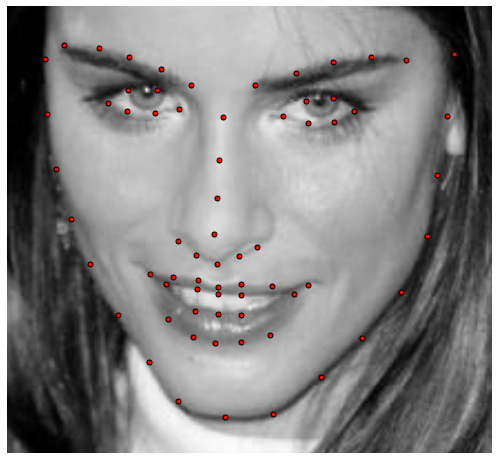

In [3]:
from menpowidgets import visualize_images

visualize_images(training_images)

## 2. Train a SDM with default parameters

Trainign an SDM using `Menpo` is rather straight forward and can be done using a single line of code.
As expected, the SDM training takes some time.

In [4]:
from menpofit.sdm import RegularizedSDM
# Note that we use fast dense sift features
# and thus cyvlfeat must be installed (use conda)
from menpo.feature import vector_128_dsift

fitter = RegularizedSDM(
    training_images, 
    verbose=True,
    group='PTS',
    diagonal=200,
    n_perturbations=30,
    n_iterations=2,
    patch_features=vector_128_dsift,
    patch_shape=(24, 24),
    alpha=10
)

- Computing reference shape                                                     Computing batch 0
- Generating 30 new bounding boxes directly from the ground truth shape: [==========] 100% (811/811) - done.
  - Scale 0: (Iteration 0) - Training error -> mean: 0.0138, std: 0.0045, median: 0.0129.
  - Scale 1: (Iteration 0) - Training error -> mean: 0.0042, std: 0.0007, median: 0.0041.


In [5]:
print(fitter)

Supervised Descent Method
 - Regression performed using the NonParametricNewton algorithm
   - Regression class: IRLRegression
 - Perturbations generated per shape: 30
 - Images scaled to diagonal: 200.00
 - Custom perturbation scheme used: False
 - Scales: [0.5, 1.0]
   - Scale 0.5
     - 1 iterations
     - Patch shape: (24, 24)
     - Holistic feature: no_op
     - Patch feature: vector_128_dsift
   - Scale 1.0
     - 1 iterations
     - Patch shape: (24, 24)
     - Holistic feature: no_op
     - Patch feature: vector_128_dsift



## 3. Fit the previous SDM

Let's try fitting the SDM to some images of the LFPW database test set!!!

In [6]:
import menpo.io as mio

# load test images
test_images = []
for i in mio.import_images(path_to_lfpw / 'testset' / '*.png', max_images=5, verbose=True):
    # crop image
    i = i.crop_to_landmarks_proportion(0.5)
    # convert it to grayscale if needed
    if i.n_channels == 3:
        i = i.as_greyscale(mode='luminosity')
    # append it to the list
    test_images.append(i)

Found 5 assets, index the returned LazyList to import.


Note that for the purpose of this simple fitting demonstration we will just fit the first 5 images of the LFPW test set.

Fitting a SDM to an image is as simple as calling its `fit` method:

In [8]:
from menpofit.fitter import noisy_shape_from_bounding_box

fitting_results = []

for i in test_images:
    gt_s = i.landmarks['PTS'].lms
    # generate perturbed landmarks
    bb = noisy_shape_from_bounding_box(fitter.reference_shape.bounding_box(), 
                                       gt_s.bounding_box())
    # fit image
    fr = fitter.fit_from_bb(i, bb, gt_shape=gt_s) 
    fitting_results.append(fr)

    # print fitting error
    print(fr)

Fitting result of 68 landmark points.
Initial error: 0.0622
Final error: 0.0243
Fitting result of 68 landmark points.
Initial error: 0.2236
Final error: 0.1592
Fitting result of 68 landmark points.
Initial error: 0.2786
Final error: 0.2504
Fitting result of 68 landmark points.
Initial error: 0.1811
Final error: 0.0850
Fitting result of 68 landmark points.
Initial error: 0.1288
Final error: 0.0508


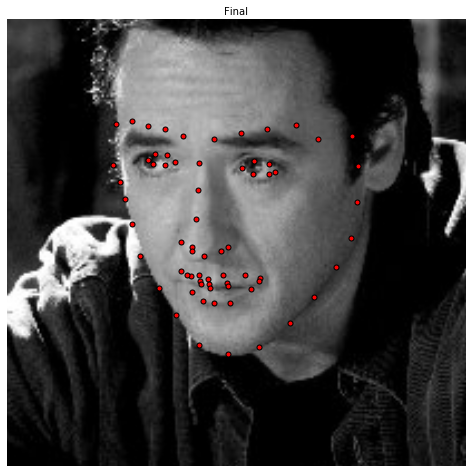

In [9]:
from menpowidgets import visualize_fitting_result

visualize_fitting_result(fitting_results)